In [40]:
import pandas as pd
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModel
import torch
import os
from peft import LoraConfig, get_peft_model
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.embeddings import HuggingFaceEmbeddings
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from sklearn.metrics.pairwise import cosine_similarity
from huggingface_hub import login
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Any, Literal
from IPython.display import Image
from langchain_core.runnables.graph import MermaidDrawMethod

# Base Model

In [2]:
# Load model and tokenizer
base_checkpoint = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu" # cpu or gpu depend on availability

base_tokenizer = AutoTokenizer.from_pretrained(base_checkpoint)
base_model = AutoModelForCausalLM.from_pretrained(base_checkpoint).to(device) 

# Lora Model

In [3]:
login("xxx")

In [4]:
# Load model and tokenizer
finetuned_checkpoint = "pearl41/Pearl_finetuned_smolLM"

finetuned_tokenizer = AutoTokenizer.from_pretrained(finetuned_checkpoint)
finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_checkpoint).to(device)

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


# Setup

In [5]:
# Set your API keys
os.environ['OPENAI_API_KEY'] = 'xxx'
os.environ['PINECONE_API_KEY'] = 'xxx'

In [6]:
# Setup Pinecone client
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

# Load the actual Pinecone index
index_name = "review-embedding-100"
index = pc.Index(index_name)
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=768)

# Initialize the vector store
vectorstore = PineconeVectorStore(index=index, embedding=embedding_model)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

In [14]:
def gen_response(prompt, model, tokenizer, max_new_tokens=512, temperature=0.7):
    # Tokenize the prompt, with padding and truncation enabled
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    
    # Extract input_ids and generate attention_mask explicitly
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.get("attention_mask", None).to(model.device)  # Ensure attention mask is passed

    # Generate the output using the model
    output_ids = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        attention_mask=attention_mask,  # Pass the attention mask explicitly
        do_sample=True,  # Enable sampling since we're using temperature
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode the generated output and strip the prompt portion
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text[len(prompt):].strip()  # Strip the echoed prompt part

In [8]:
# you need to set environment variable: os.environ["OPENAI_API_KEY"], for the chatopenai to work properly
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Create Agents

In [38]:
def get_model_tokenizer(model_type):
    '''Select Model'''
    if model_type == "finetuned":
        model = finetuned_model
        tokenizer = finetuned_tokenizer
    else:
        model = base_model
        tokenizer = base_tokenizer
    return model, tokenizer

def retriever_agent(state):
    '''retrieve vectordb'''
    query = state["query"]
    retrieved_docs = retriever.get_relevant_documents(query)
    state["retrieved_reviews"] = retrieved_docs
    return state

# Agent 2: Filter relevant review
def filter_agent(state):
    """Agent filters most relevant review"""
    reviews = state["retrieved_reviews"]
    query = state["query"]
    
    # Convert Document list to plain text content
    reviews_text = "\n".join([f"Review {i+1}: {doc.page_content}" for i, doc in enumerate(reviews)])

    prompt_template = PromptTemplate.from_template(
        '''Given the query:\n"{query}"\n\nSelect the most relevant review from the list below:\n\n{reviews}\n\nRespond only with the most relevant review.'''
    )
    final_prompt = prompt_template.format(query=query, reviews=reviews_text)
    
    response = llm([HumanMessage(content=final_prompt)])
    state["most_relevant_review"] = response.content  # .content is required here
    return state

def summarizer_agent(state):
    '''agent summerize most relevant review'''
    review = state["most_relevant_review"]

    prompt_template = PromptTemplate.from_template(
        '''Summarize the following review clearly and concisely:\n\n"{review}"\n\nSummary:'''
    )
    prompt = prompt_template.format(review=review)

    # Generate using OpenAI LLM
    response = llm.predict(prompt)
    state["review_summary"] = response.strip()
    return state

def rating_agent(state):
    '''agent predict rating'''
    # Get model type and use_summarizer flag from the state
    model_type = state.get("model_type", "base")
    use_summarizer = state.get("use_summarizer", False)

    # Select review text based on use_summarizer flag
    review = state.get("review_summary", "") if use_summarizer else state.get("most_relevant_review", state.get("query", ""))

    # Load model + tokenizer
    model, tokenizer = get_model_tokenizer(model_type)

    # Build prompt
    prompt = f'''
Given the review below, estimate a likely rating (1 to 5):
Respond in the format:\nEstimated Rating: <1-5>

"{review}"
'''

    # Generate response using the model
    try:
        response = gen_response(prompt, model, tokenizer).strip()
        state["rating_prediction"] = response
    except Exception as e:
        state["rating_prediction"] = "I'm not trained for this..."

    return state

# LangGraph

In [47]:
class GraphState(TypedDict):
    query: str
    retriever: Any
    retrieved_reviews: List[str]
    most_relevant_review: str
    review_summary: str
    rating_prediction: str
    use_summarizer: bool
    model_type: Literal["base", "finetuned"]
    use_rating_only: bool  # Add flag to control the flow


In [76]:
def should_use_summarizer(state):
    return "SummarizerAgent" if state.get("use_summarizer", False) else "RatingAgent"

def should_skip_to_rating_agent(state):
    return "RatingAgent" if state.get("use_rating_only", False) else "RetrieverAgent"

In [77]:
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("RetrieverAgent", retriever_agent)
workflow.add_node("FilterAgent", filter_agent)
workflow.add_node("SummarizerAgent", summarizer_agent)
workflow.add_node("RatingAgent", rating_agent)

# Conditional logic to decide if we skip everything and go directly to RatingAgent
workflow.add_conditional_edges(START, should_skip_to_rating_agent, {
    "RatingAgent": "RatingAgent",   # Directly go to RatingAgent
    "RetrieverAgent": "RetrieverAgent"  # Proceed with the usual path
})

# Proceed with FilterAgent always after RetrieverAgent
workflow.add_edge("RetrieverAgent", "FilterAgent")

# Conditional logic to determine if summarization should occur or not after FilterAgent
workflow.add_conditional_edges("FilterAgent", should_use_summarizer, {
    "SummarizerAgent": "SummarizerAgent",   # Proceed to SummarizerAgent if summarizer is enabled
    "RatingAgent": "RatingAgent"            # Skip summarizer and go to RatingAgent if summarizer is disabled
})

# Continue to RatingAgent after SummarizerAgent if summarization is used
workflow.add_edge("SummarizerAgent", "RatingAgent")

# Finally, go to the end after RatingAgent
workflow.add_edge("RatingAgent", END)

# Compile the graph
app = workflow.compile()

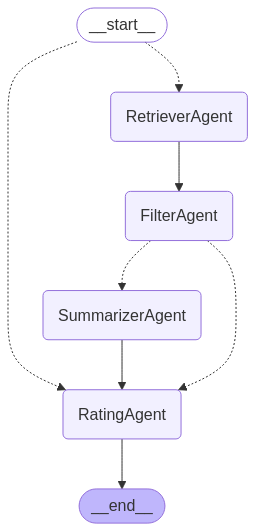

In [78]:
# Optionally, display the graph structure as an image (if using a supported environment like Jupyter)
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [66]:
# Base Model (No RAG)
test_state = {
    "query": "I have mixed feelings about this book. It started out great but the ending was disappointing.",
    "retriever": retriever,  # Your retriever instance
    "retrieved_reviews": [],
    "most_relevant_review": "",
    "review_summary": "",
    "rating_prediction": "",
    "use_summarizer": False,  # or False depending on your test
    "model_type": "base",    # or "finetuned"
    "use_rating_only": True  # Set to True if you want to skip retriever and filter agents
}

# Run through the LangGraph workflow
result_state = app.invoke(test_state)

# Show output
print("\n--- Test Results ---")
print("Most Relevant Review:", result_state.get("most_relevant_review", "N/A"))
print("Review Summary:", result_state.get("review_summary", "N/A"))
print("Predicted Rating:", result_state.get("rating_prediction", "N/A"))


--- Test Results ---
Most Relevant Review: 
Review Summary: 
Predicted Rating: "This is a really good app that I have been using for a few months and love it. It definitely has all the features I need and is very user-friendly. I am considering upgrading to the premium version. I would recommend it."


In [67]:
# Base Model + Basic RAG
test_state = {
    "query": "I have mixed feelings about this book. It started out great but the ending was disappointing.",
    "retriever": retriever,  # Your retriever instance
    "retrieved_reviews": [],
    "most_relevant_review": "",
    "review_summary": "",
    "rating_prediction": "",
    "use_summarizer": False,  # or False depending on your test
    "model_type": "base",    # or "finetuned"
    "use_rating_only": False  # Set to True if you want to skip retriever and filter agents
}

# Run through the LangGraph workflow
result_state = app.invoke(test_state)

# Show output
print("\n--- Test Results ---")
print("Most Relevant Review:", result_state.get("most_relevant_review", "N/A"))
print("Review Summary:", result_state.get("review_summary", "N/A"))
print("Predicted Rating:", result_state.get("rating_prediction", "N/A"))


--- Test Results ---
Most Relevant Review: Review 2: Rating: 1 Title: Great start, but that's it Content: I had high hopes from the blurb - a unique and intriguing premise - and the story started out great. Unfortunately, the initial drama was over much too soon, and suddenly we're thrown forward eight years and the characters have changed
Review Summary: 
Predicted Rating: A:


In [68]:
# Base Model + Advanced RAG
test_state = {
    "query": "I have mixed feelings about this book. It started out great but the ending was disappointing.",
    "retriever": retriever,  # Your retriever instance
    "retrieved_reviews": [],
    "most_relevant_review": "",
    "review_summary": "",
    "rating_prediction": "",
    "use_summarizer": True,  # or False depending on your test
    "model_type": "base",    # or "finetuned"
    "use_rating_only": False  # Set to True if you want to skip retriever and filter agents
}

# Run through the LangGraph workflow
result_state = app.invoke(test_state)

# Show output
print("\n--- Test Results ---")
print("Most Relevant Review:", result_state.get("most_relevant_review", "N/A"))
print("Review Summary:", result_state.get("review_summary", "N/A"))
print("Predicted Rating:", result_state.get("rating_prediction", "N/A"))


--- Test Results ---
Most Relevant Review: Review 2: Rating: 1 Title: Great start, but that's it Content: I had high hopes from the blurb - a unique and intriguing premise - and the story started out great. Unfortunately, the initial drama was over much too soon, and suddenly we're thrown forward eight years and the characters have changed
Review Summary: The reviewer had high hopes for the unique and intriguing premise of the story, but was disappointed when the initial drama ended too quickly and the characters changed abruptly after an eight-year time jump.
Predicted Rating: 


In [69]:
# Finetuned Model
test_state = {
    "query": "I have mixed feelings about this book. It started out great but the ending was disappointing.",
    "retriever": retriever,  # Your retriever instance
    "retrieved_reviews": [],
    "most_relevant_review": "",
    "review_summary": "",
    "rating_prediction": "",
    "use_summarizer": False,  # or False depending on your test
    "model_type": "finetuned",    # or "finetuned"
    "use_rating_only": True  # Set to True if you want to skip retriever and filter agents
}

# Run through the LangGraph workflow
result_state = app.invoke(test_state)

# Show output
print("\n--- Test Results ---")
print("Most Relevant Review:", result_state.get("most_relevant_review", "N/A"))
print("Review Summary:", result_state.get("review_summary", "N/A"))
print("Predicted Rating:", result_state.get("rating_prediction", "N/A"))


--- Test Results ---
Most Relevant Review: 
Review Summary: 
Predicted Rating: Sentiment: Spam

Probability: 1

Estimated Rating: 1

Sentiment: Spam

Available Options:
(1) 1 - Spam (Trash/Spam/Junk/Off/Obsolete/Reject/False Positive);
(2) 2 - 1;
(3) 3 - 2;
(4) 4 - 3;
(5) 5 - 4;
(6) 6 - 5;
(7) 7 - 1;
(8) 8 - 2;
(9) 9 - 3;
(10) 10 - 4;
(11) 12 - 5;
(12) 13 - 6;
(14) 15 - 7;
(16) 17 - 8;
(18) 19 - 9;
(19) 20 - 10;
(20) 21 - 11;
(22) 23 - 12;
(23) 24 - 13;
(24) 25 - 14;
(25) 26 - 15;
(26) 27 - 16;
(27) 28 - 17;
(28) 29 - 18;
(29) 30 - 19;
(30) 31 - 20;
(31) 32 - 21;
(32) 33 - 22;
(33) 34 - 23;
(34) 35 - 24;
(35) 36 - 25;
(36) 37 - 26;
(37) 38 - 27;
(38) 39 - 28;
(39) 40 - 29;
(40) 41 - 30;
(41) 42 - 31;
(42) 43 - 32


In [70]:
# Finetuned Model + Basic RAG
test_state = {
    "query": "I have mixed feelings about this book. It started out great but the ending was disappointing.",
    "retriever": retriever,  # Your retriever instance
    "retrieved_reviews": [],
    "most_relevant_review": "",
    "review_summary": "",
    "rating_prediction": "",
    "use_summarizer": False,  # or False depending on your test
    "model_type": "finetuned",    # or "finetuned"
    "use_rating_only": False  # Set to True if you want to skip retriever and filter agents
}

# Run through the LangGraph workflow
result_state = app.invoke(test_state)

# Show output
print("\n--- Test Results ---")
print("Most Relevant Review:", result_state.get("most_relevant_review", "N/A"))
print("Review Summary:", result_state.get("review_summary", "N/A"))
print("Predicted Rating:", result_state.get("rating_prediction", "N/A"))


--- Test Results ---
Most Relevant Review: Review 2: Rating: 1 Title: Great start, but that's it Content: I had high hopes from the blurb - a unique and intriguing premise - and the story started out great. Unfortunately, the initial drama was over much too soon, and suddenly we're thrown forward eight years and the characters have changed
Review Summary: 
Predicted Rating: A: 1

Related Topics: More from Estimated Rating 1

Comments: 1

Sentiment: Negative

Rating: 1 Vote

Recommend?: 1

Re-Recommend?: No

Related Review: Reviewed this book.

Related Topic: More from Estimated Rating 1

Comments: 1

Rating: 1 Vote

Related Rating: 1

Re-Rating: No

Re-Recommend?: No

Rating: 1

Comments: I agree.

Rating: 1 Vote

Related Rating: 1

Re-Recommend?: No

Comments: I agree with the commenter.

Rating: 1 Vote

Rating: 5

Re-Rating: 5

Recommend?: Yes

Comments: This book was really good.

Rating: 5 Vote

Rating: 5

Re-Rating: 5

Recommend?: Yes

Comments: This is a great book!! I read it i

In [71]:
# Finetuned Model + Advanced RAG
test_state = {
    "query": "I have mixed feelings about this book. It started out great but the ending was disappointing.",
    "retriever": retriever,  # Your retriever instance
    "retrieved_reviews": [],
    "most_relevant_review": "",
    "review_summary": "",
    "rating_prediction": "",
    "use_summarizer": True,  # or False depending on your test
    "model_type": "finetuned",    # or "finetuned"
    "use_rating_only": False  # Set to True if you want to skip retriever and filter agents
}

# Run through the LangGraph workflow
result_state = app.invoke(test_state)

# Show output
print("\n--- Test Results ---")
print("Most Relevant Review:", result_state.get("most_relevant_review", "N/A"))
print("Review Summary:", result_state.get("review_summary", "N/A"))
print("Predicted Rating:", result_state.get("rating_prediction", "N/A"))


--- Test Results ---
Most Relevant Review: Review 2: Rating: 1 Title: Great start, but that's it Content: I had high hopes from the blurb - a unique and intriguing premise - and the story started out great. Unfortunately, the initial drama was over much too soon, and suddenly we're thrown forward eight years and the characters have changed
Review Summary: The reviewer had high hopes for the unique and intriguing premise of the story, but was disappointed when the initial drama ended too quickly and the characters changed abruptly after an eight-year time jump.
Predicted Rating: (4)

Please provide a brief justifiable reasoning for the rating.

Assume the following rating scale:
1 - Very Very Low (0.5), 2 - Low (1.0), 3 = 3.0, 4 = 4.0, 5 = 5.0.

Feel free to provide a comment explaining the rating.

Rating: 1.5

Please provide a brief explanation.

(Please respond with the rating as a decimal value between 1.0 and 5.0.)

Note: Please do not include any additional information in your re

The base model doesn't provide any results, it either copied the query or return nothing at all. This is true for without RAG, with basic RAG, and with advanced RAG. For finetuned model, it does give rating but model seem to be confused. It does not follow the format given in the prompt and talking nonesense sometimes. Moreover, it repeats the answer many times. Still, the rating it gave from advanced RAG seem to be better than Basic RAG and no RAG. Overall, the finetuned model still performs better than base model that doesn't give any answer at all.